In [1]:
from pathlib import Path

path = Path('../input/house-prices-advanced-regression-techniques')
!pip install -Uqq fastai

Get Data

In [2]:
from fastai.tabular.all import *

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

import torch, pandas as pd

df = pd.read_csv(path/'train.csv')
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.00,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.00,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.00,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.00,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.00,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.00,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [3]:
df.mode().iloc[0]

Id                      1
MSSubClass          20.00
MSZoning               RL
LotFrontage         60.00
LotArea           7200.00
                   ...   
MoSold               6.00
YrSold            2009.00
SaleType               WD
SaleCondition      Normal
SalePrice       140000.00
Name: 0, Length: 81, dtype: object

In [4]:
def add_features(dataframe):
    CURRENT_YEAR = 2023
    dataframe['BuiltAge'] = CURRENT_YEAR - dataframe['YearBuilt']
    dataframe['RemodAddAge'] = CURRENT_YEAR - dataframe['YearRemodAdd']
    dataframe['GarageAge'] = CURRENT_YEAR - dataframe['GarageYrBlt']
    dataframe['SoldAge'] = CURRENT_YEAR - dataframe['YrSold']
add_features(df)

Split Data

In [5]:
splits = RandomSplitter(seed=42)(df)

In [6]:
dls = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
    cont_names=['LotArea', 'LotFrontage', 'OverallQual', 'OverallCond', 'BuiltAge', 'RemodAddAge', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageAge', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'SoldAge'],
    y_names="SalePrice", y_block = RegressionBlock(),
).dataloaders(path=".")

# dls = TabularPandas(
#     df, splits=splits,
#     procs = [Categorify, FillMissing, Normalize],
#     cat_names=[],
#     cont_names=['GrLivArea'],
#     y_names="SalePrice", y_block = RegressionBlock(),
# ).dataloaders(path=".")

Training

SuggestedLRs(slide=6.309573450380412e-07, valley=0.43651583790779114)

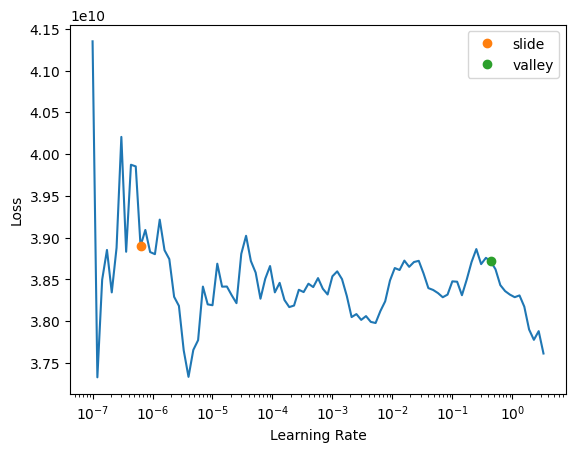

In [7]:
learn = tabular_learner(dls, metrics=rmse, layers=[10,10])
learn.lr_find(suggest_funcs=(slide, valley))

In [8]:
learn.fit(50, lr=0.01)

epoch,train_loss,valid_loss,_rmse,time
0,37826285568.000000,42046251008.000000,205051.828125,00:00
1,38023286784.000000,42047340544.000000,205054.484375,00:00
2,38247677952.000000,42045054976.000000,205048.906250,00:00
3,38252474368.000000,42040844288.000000,205038.625000,00:00
4,38210605056.000000,42036682752.000000,205028.500000,00:00
5,38186246144.000000,42037239808.000000,205029.843750,00:00
6,38214680576.000000,42035187712.000000,205024.843750,00:00
7,38254198784.000000,42026622976.000000,205003.953125,00:00
8,38221971456.000000,42017153024.000000,204980.843750,00:00
9,38210473984.000000,42012086272.000000,204968.500000,00:00


Packaging model data to submit to Kaggle

In [9]:
tst_df = pd.read_csv(path/'test.csv')
tst_df['BsmtFinSF1'] = tst_df.BsmtFinSF1.fillna(0)
tst_df['BsmtFinSF2'] = tst_df.BsmtFinSF2.fillna(0)
tst_df['TotalBsmtSF'] = tst_df.TotalBsmtSF.fillna(0)
tst_df['BsmtFullBath'] = tst_df.BsmtFullBath.fillna(0)
tst_df['BsmtHalfBath'] = tst_df.BsmtHalfBath.fillna(0)
tst_df['GarageCars'] = tst_df.GarageCars.fillna(0)
tst_df['GarageArea'] = tst_df.GarageArea.fillna(0)
add_features(tst_df)
tst_dl = learn.dls.test_dl(tst_df)
preds,_ = learn.get_preds(dl=tst_dl)
preds


tensor([[ 347.7463],
        [1146.4448],
        [1228.3480],
        ...,
        [ 894.8818],
        [  58.1642],
        [1538.4128]])

In [10]:
tst_df['SalePrice'] = (preds[:]).int()
sub_df = tst_df[['Id', 'SalePrice']]
sub_df.to_csv('sub.csv', index=False)

sub.csv can be submitted to Kaggle.